# Text Processing for Accelerator project

A simplified pipeline processing text with FastText.

* Load CPA classification data and removal of unwanted text
* Basic text cleaning
* Vectorize (with FastText)
* examine the vectorization using UMAP on one hand and PCA + TSNE on the other 
* Cluster (HDBSCAN)
* Evaluate
* Visualise

In [1]:
# this bit shouldn't be necessary if we pip install -e .   in the parent directory
%load_ext autoreload
%autoreload 2

In [2]:
import functools
from pprint import pprint
from time import time
from IPython.display import display, HTML
import logging
import pandas as pd
import numpy as np
import plotly.express

In [3]:
import text_processing

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load in the CPA data

In [4]:
CPA = text_processing.fetch_files()

2020-12-02 13:15:54,489 - text_processing - INFO - cleanded CPA File imported


In [5]:
CPA[CPA.Includes.notnull()].head()

Order  Level      Code   Parent  \
3   1208795      4     01.11     01.1   
19  1208811      6  01.11.50  01.11.5   
22  1208814      6  01.11.62  01.11.6   
24  1208816      5   01.11.7    01.11   
56  1208848      6  01.13.19  01.13.1   

                                            Descr_old  \
3   Cereals (except rice), leguminous crops and oi...   
19                            Cereals straw and husks   
22                                        Peas, green   
24                        Dried leguminous vegetables   
56                     Other leafy or stem vegetables   

                                       Descr  \
3   Cereals , leguminous crops and oil seeds   
19                   Cereals straw and husks   
22                               Peas, green   
24               Dried leguminous vegetables   
56            Other leafy or stem vegetables   

                                             Includes Category_2 Category_3  \
3   cereals, leguminous crops and oil seeds grown ...         01       01.1   
19  unprepared straw, whether or not chopped, grou...         01       01.1   
22                         green peas and forage peas         01       01.1   
24   leguminous vegetables, dried, whether or not ...         01       01.1   
56                                            parsley         01       01.1   

   Category_1 Category_0  
3           A          1  
19          A          1  
22          A          1  
24          A          1  
56          A          1

In [6]:
CPA1 = CPA[['Code','Descr_old','Descr','Category_0','Category_1','Category_2']].copy()
df = text_processing.clean_col(CPA1, "Descr")
df.drop('Descr',axis=1,inplace=True)

2020-12-02 13:16:04,667 - text_processing - INFO - Cleaning column: Descr 


In [7]:
df.sample(5)

Code                                          Descr_old Category_0  \
5509     98.10  Undifferentiated goods produced by private hou...         10   
4105   50.40.1            Inland freight water transport services          4   
5159     84.24                   Public order and safety services          9   
5357   91.04.1  Botanical and zoological garden services and n...         10   
5048  80.10.12                                     Guard services          8   

     Category_1 Category_2                                      Descr_cleaned  
5509          T         98  undifferentiated goods produced private househ...  
4105          H         50            inland freight water transport services  
5159          O         84                       public order safety services  
5357          R         91  botanical zoological garden services nature re...  
5048          N         80                                     guard services

## Load FastText Pretrained

Note: This requires a fair bit of memory (peaks at about 17.5 GiB)

Recommend shutting down other kernels first, once this has loaded memory usage drops again.

This takes a few minutes to load in.

In [8]:
wv = text_processing.fetch_fasstext_pretrained(filepath="../../data/wiki.en.bin")

2020-12-02 13:16:07,534 - text_processing - INFO - Loading FastText pretrained from ../../data/wiki.en.bin
2020-12-02 13:20:15,338 - text_processing - INFO - Model loaded


## Vectorize descriptions using FastText

In [9]:
text_to_vec = functools.partial(text_processing.vectorize_text, wv)

df["Descr_cleaned_vectorized"] = df.Descr_cleaned.apply(
    text_to_vec
)

### Repeat earlier work on dimensionality reduction using PCA and TSNE

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

X = np.array(list(df["Descr_cleaned_vectorized"]))

pca = PCA(n_components=10)
X_r = pca.fit(X).transform(X)

# reduce dimension with PCA
PCA_df = df.copy()
PCA_df['PCA_X'] = X_r[:,0]
PCA_df['PCA_Y'] = X_r[:,1]

PCA_df['PCA_X'] = X_r[:,0]
PCA_df['PCA_Y'] = X_r[:,1]


# reduce dimension with TSNE
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000, verbose=0)

tsne_data = model.fit_transform(X_r)
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2"))
tsne_df2 = df.copy()
tsne_df2['dim1'] = tsne_data[:,0]
tsne_df2['dim2'] = tsne_data[:,1]
#plot_scat(tsne_df2, Cat_0_descrip,'PCA and TSNE analysis - Scikit vectorisation')


2020-12-02 13:23:00,107 - text_processing - INFO - cleanded CPA File imported
2020-12-02 13:23:00,298 - text_processing - INFO - cleanded CPA File imported


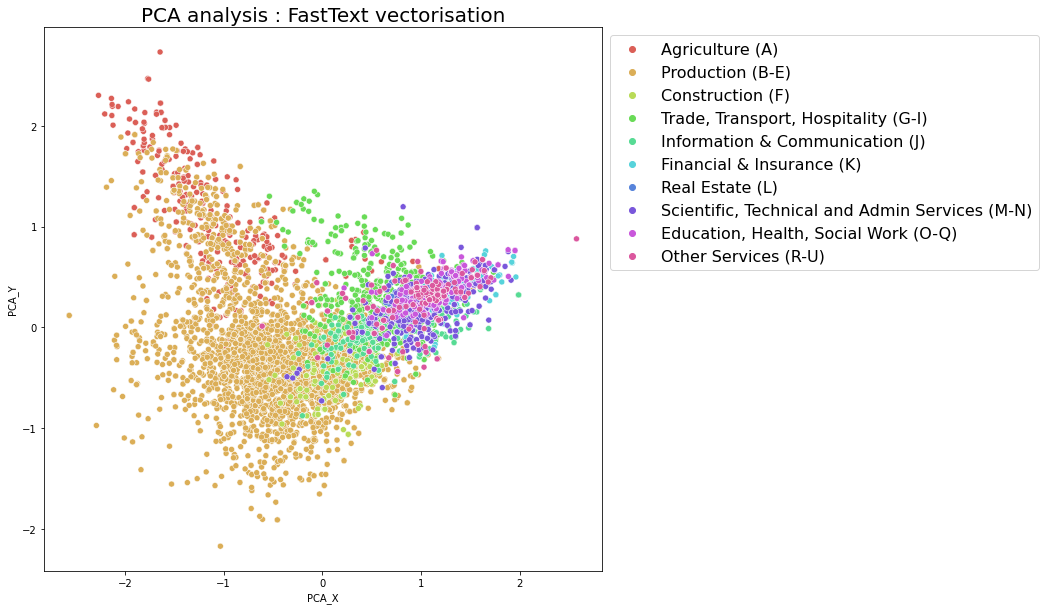

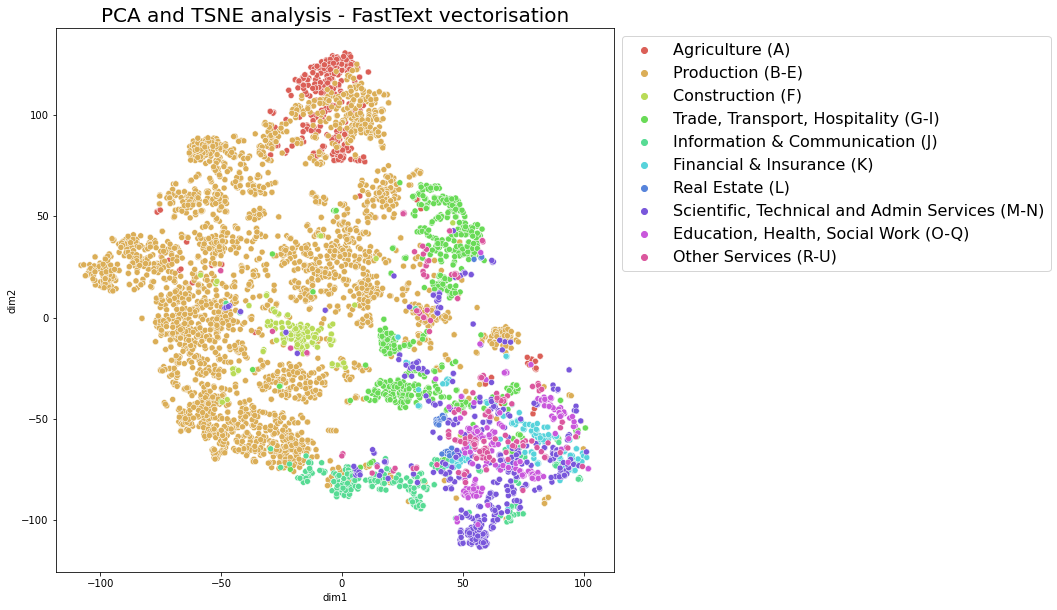

In [11]:
text_processing.plot_scat(PCA_df, '0', 'PCA analysis : FastText vectorisation')
text_processing.plot_scat(tsne_df2, '0', 'PCA and TSNE analysis - FastText vectorisation')

## Dimensionality Reduction - UMAP with 2 dimensions and TSNE to compare what was done before

2020-12-02 13:23:02,809 - text_processing - INFO - Now applying umap to reduce dimension


UMAP(min_dist=0.0, n_neighbors=10, random_state=3052528580, verbose=10)
Construct fuzzy simplicial set
Wed Dec  2 13:23:02 2020 Finding Nearest Neighbors
Wed Dec  2 13:23:02 2020 Building RP forest with 9 trees
Wed Dec  2 13:23:04 2020 NN descent for 12 iterations
	 0  /  12
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	 7  /  12
	 8  /  12
	 9  /  12
	 10  /  12
Wed Dec  2 13:23:10 2020 Finished Nearest Neighbor Search
Wed Dec  2 13:23:12 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Dec  2 13:23:25 2020 Finished embedding


2020-12-02 13:25:44,151 - text_processing - INFO - cleanded CPA File imported
2020-12-02 13:25:44,405 - text_processing - INFO - cleanded CPA File imported


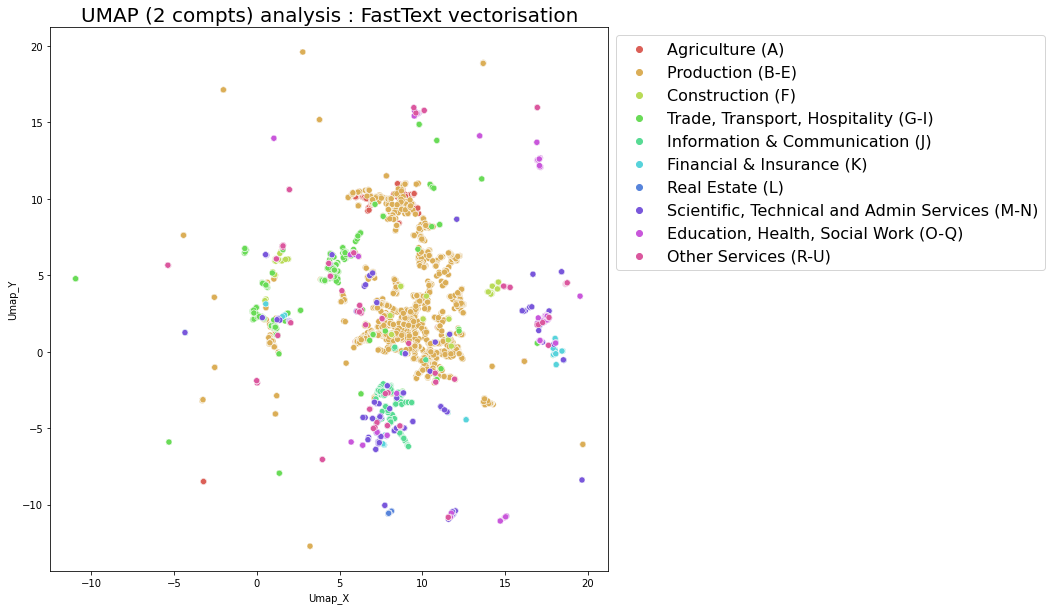

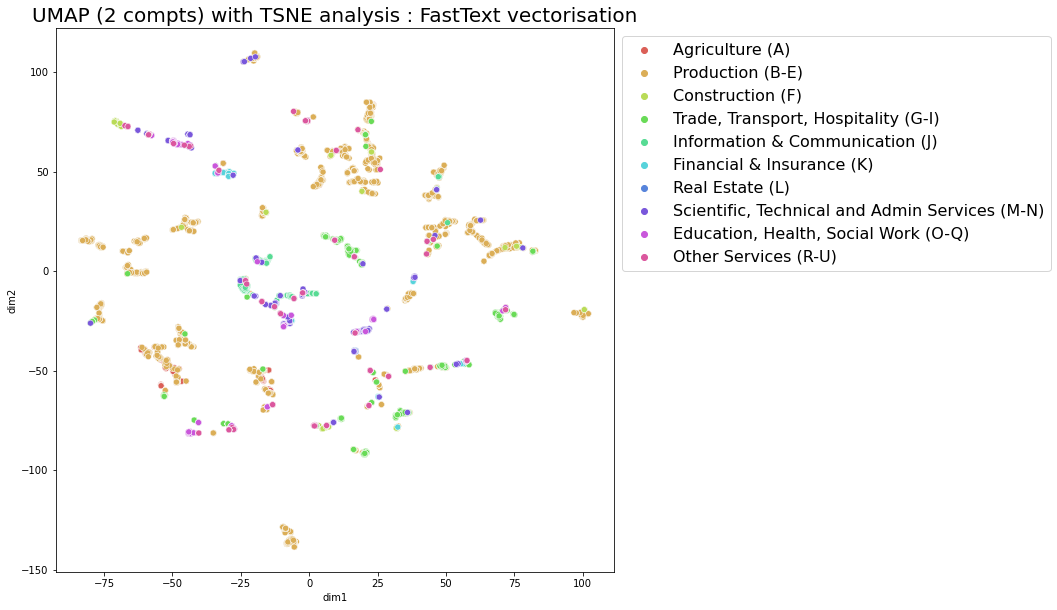

In [12]:
df["Low_dim_2"] = text_processing.reduce_dimensionality(
    df.Descr_cleaned_vectorized, 2
)

X2_r = np.array(list(df.Low_dim_2))
df3 = df.copy()
df3['Umap_X'] = X2_r[:,0]
df3['Umap_Y'] = X2_r[:,1]


tsne_data2 = model.fit_transform(X2_r)
tsne_df_new = pd.DataFrame(data=tsne_data2, columns=("dim1", "dim2"))
tsne_df3 = df.copy()
tsne_df3['dim1'] = tsne_data2[:,0]
tsne_df3['dim2'] = tsne_data2[:,1]

text_processing.plot_scat(df3, '0', 'UMAP (2 compts) analysis : FastText vectorisation')
text_processing.plot_scat(tsne_df3, '0', 'UMAP (2 compts) with TSNE analysis : FastText vectorisation')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2020-12-02 14:56:52,266 - text_processing - INFO - cleanded CPA File imported
2020-12-02 14:56:52,266 - text_processing - INFO - cleanded CPA File imported
2020-12-02 14:56:52,266 - text_processing - INFO - cleanded CPA File imported
/home/jupyter/Data-science-accelerator/src/text_processing.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cat_1_descrip.loc[Cat_1_descrip.Category_1=='T']['Cat_1_Description'] = 'hello'
2020-12-02 14:56:52,534 - text_processing - INFO - cleanded CPA File imported
2020-12-02 14:56:52,534 - text_processing - INFO - cleanded CPA File imported
2020-12-02 14:56:52,534 - text

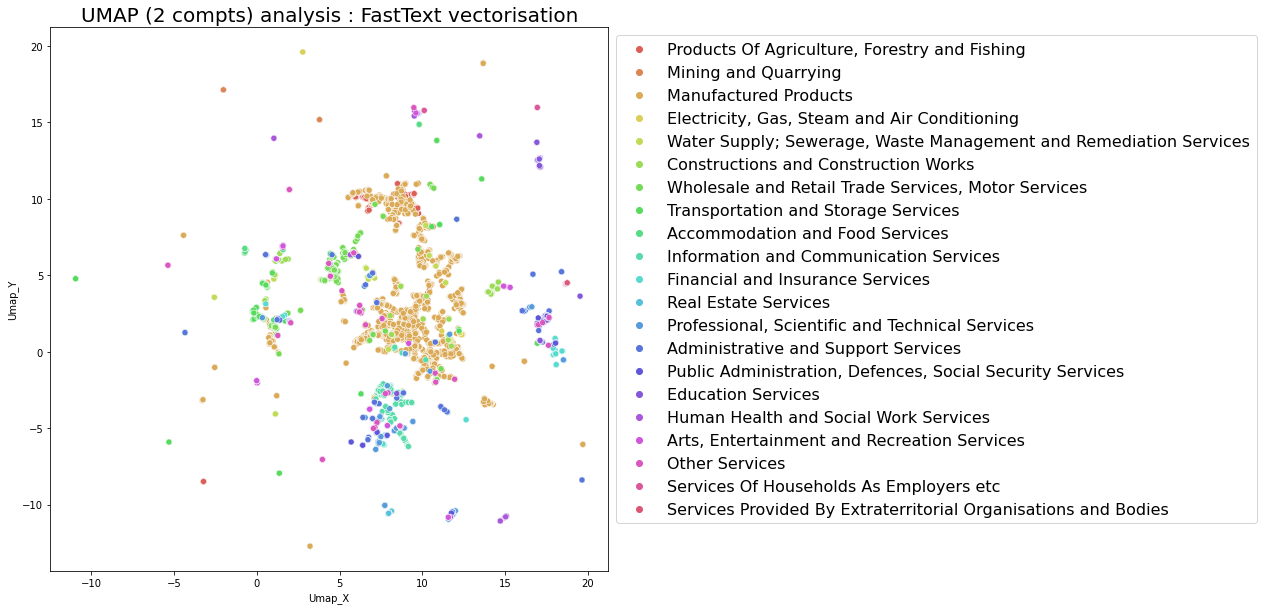

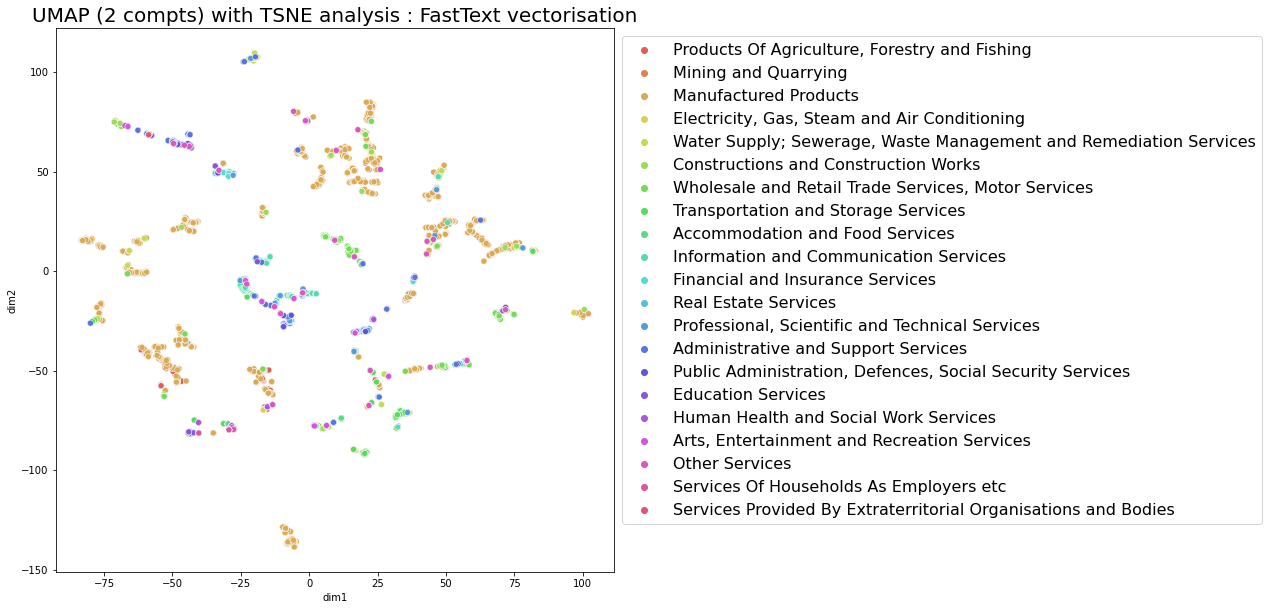

In [15]:
#text_processing.plot_scat(df3, '1', 'UMAP (2 compts) analysis : FastText vectorisation')
#text_processing.plot_scat(tsne_df3, '1', 'UMAP (2 compts) with TSNE analysis : FastText vectorisation')

fig1 = text_processing.plotly_scat(plot_df,['Descr_cleaned','label'], 'Dimension reduction with UMAP: 2 of 10 dimensions')
fig1.update_layout()

## Dimensionality Reduction - UMAP with 10 dimensions 

In [50]:
# let's look again only at lowest level, level 6
df4 = df[df.Code.str.len()>7]
df4["Low_dim_10"] = text_processing.reduce_dimensionality(
    df4.Descr_cleaned_vectorized, 10
)

2020-12-02 16:28:18,977 - text_processing - INFO - Now applying umap to reduce dimension
2020-12-02 16:28:18,977 - text_processing - INFO - Now applying umap to reduce dimension
2020-12-02 16:28:18,977 - text_processing - INFO - Now applying umap to reduce dimension


UMAP(min_dist=0.0, n_components=10, n_neighbors=10, random_state=3052528580,
     verbose=10)
Construct fuzzy simplicial set
Wed Dec  2 16:28:25 2020 Finding Nearest Neighbors
Wed Dec  2 16:28:28 2020 Finished Nearest Neighbor Search
Wed Dec  2 16:28:29 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Dec  2 16:28:40 2020 Finished embedding


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2020-12-02 16:53:28,929 - text_processing - INFO - cleanded CPA File imported
2020-12-02 16:53:28,929 - text_processing - INFO - cleanded CPA File imported
2020-12-02 16:53:28,929 - text_processing - INFO - cleanded CPA File imported
2020-12-02 16:53:28,929 - text_processing - INFO - cleanded CPA File imported
2020-12-02 16:53:28,929 - text_processing - INFO - cleanded CPA File imported
2020-12-02 16:53:28,929 - text_processing - INFO - cleanded CPA File imported
2020-12-02 16:53:28,929 - text_processing - INFO - cleanded CPA File imported
2020-12-02 16:53:28,929 - text_processing - INFO - cleanded CPA File imported
/home/jupyter/Data-science-accelerator/src/text_processing.py:142: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



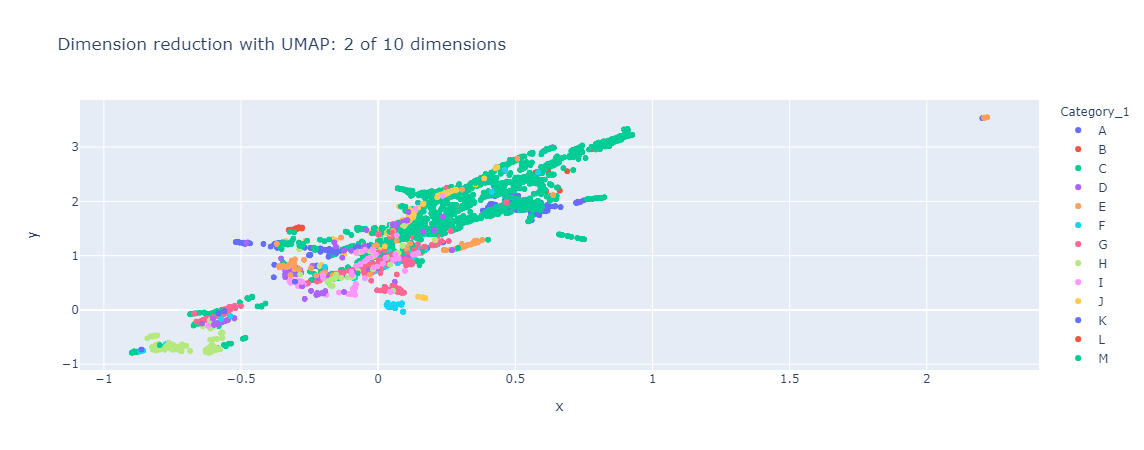

In [65]:
plot_df = df4[["Category_1","Descr_cleaned", "Code", "Low_dim_10","label"]].copy()
plot_df['Category'] = plot_df['Category_1'].astype(str)
i=2
plot_df["x"] = plot_df.Low_dim_10.apply(lambda x: x[2*i])
plot_df["y"] = plot_df.Low_dim_10.apply(lambda x: x[2*i+1])

fig1 = text_processing.plotly_scat(plot_df,'1',['Descr_cleaned','label'], 'Dimension reduction with UMAP: 2 of 10 dimensions')
fig1.update_layout()


### Clustering

In [88]:
df5 = df4.copy()
df5["label"] = text_processing.cluster(df.Low_dim_10)
df5['New_cat'] = df.label.astype(str)

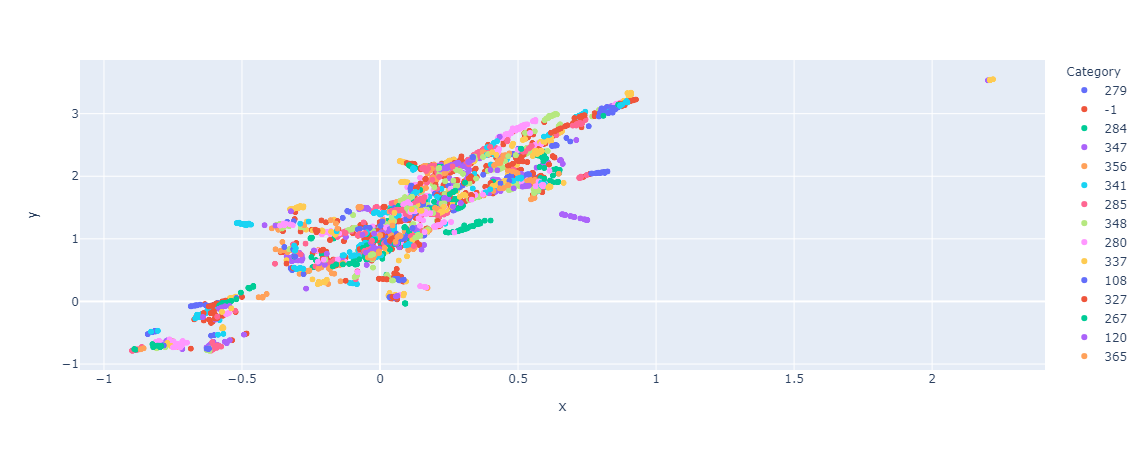

In [89]:


plot_df = df5[["Category_1","Descr_cleaned", "Code", "Low_dim_10","label"]].copy()
plot_df['Category'] = plot_df.label.astype(str)

plot_df["x"] = plot_df.Low_dim_10.apply(lambda x: x[4])
plot_df["y"] = plot_df.Low_dim_10.apply(lambda x: x[5])
# add filtering
# a function to produce a scatter plot
def scat(plot_df, true_cols):
    hover = {
        "Category":False,
        "x": False,
        "y": False
        }
    for col in true_cols:
        hover[col] = True
    fig = plotly.express.scatter(
            plot_df, 
            x="x", 
            y="y", 
            color="Category",
            hover_data=hover)
    return fig
#fig1 = text_processing.plotly_scat(plot_df,'label',['Descr_cleaned','label'], 'Dimension reduction with UMAP: 2 of 10 dimensions')



fig1 = scat(plot_df,['Descr_cleaned','label'])
fig1.update_layout()

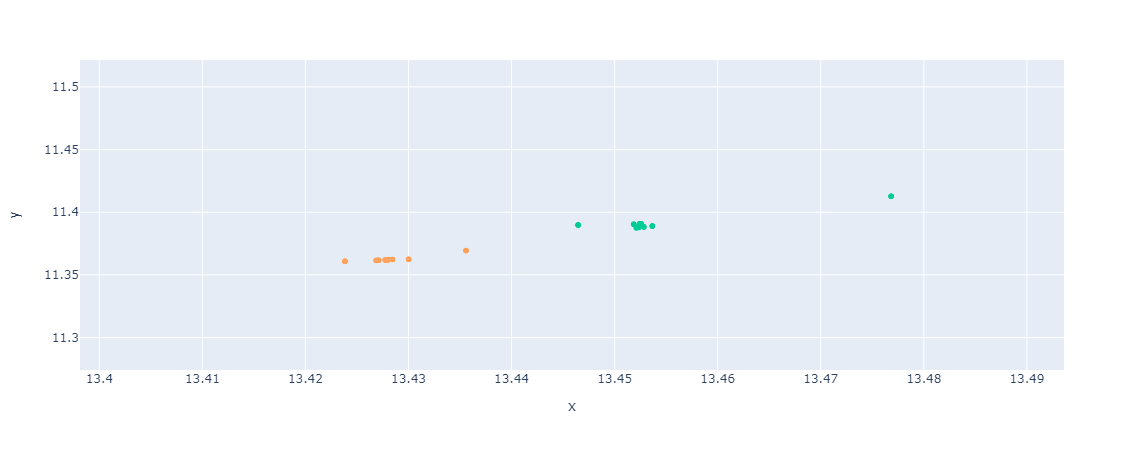

In [47]:
# plot_df = df[["Category_0","Descr_cleaned", "Code", "Low_dim_10","label"]].copy()

# plot_df["x"] = plot_df.Low_dim_10.apply(lambda x: x[4])
# plot_df["y"] = plot_df.Low_dim_10.apply(lambda x: x[5])
# # add filtering
# plot_df = plot_df[plot_df.x >3]

# plot_df["Category"] = plot_df.label.astype(str)

# fig1 = scat(plot_df, ['Descr_cleaned','label'])
# fig1.update_layout(showlegend=False)

In [90]:
plot_df[plot_df.label==3]

Category_1                                               Descr_cleaned  \
5082          N                                     home garden maintenance   
5447          S  repair services household appliances home garden equipment   
5453          S                  repair services furniture home furnishings   

          Code  \
5082  81.30.11   
5447  95.22.10   
5453  95.24.10   

                                                                                                                                                                                                      Low_dim_10  \
5082  [0.4204351007938385, 5.5658159255981445, 7.0078606605529785, 3.9555468559265137, -0.0031558386981487274, 0.7748336791992188, 4.054193019866943, 6.414247989654541, 3.9218273162841797, 1.7639362812042236]   
5447      [0.3994385898113251, 5.547585964202881, 7.008594512939453, 3.829468250274658, -0.00315038557164371, 0.8000601530075073, 3.9725735187530518, 6.4123921394348145, 3.899315118789673, 1.7875293493270874]   
5453       [0.36911216378211975, 5.5821533203125, 6.8951287269592285, 3.838308572769165, 0.017060991376638412, 0.8525226712226868, 4.020883083343506, 6.411621570587158, 3.8834164142608643, 1.8432997465133667]   

      label Category         x         y  
5082      3        3 -0.003156  0.774834  
5447      3        3 -0.003150  0.800060  
5453      3        3  0.017061  0.852523

## Investigate the new categories

In [28]:
pd.set_option('display.max_colwidth', None)

In [94]:
lab = 3
cols = ['Code','Descr_cleaned','label','Category_2']
test_case = df4[(df4.label==lab)]
display(HTML(f'<h3>These are all the low level items with label {lab}</h3>'), test_case[cols])

cat = test_case.Category_2.values[0]
tmp = df4[df4.Category_2 == cat]
display(HTML(f'<h3>These are all the items with category {cat}</h3>'), 
tmp[cols].sort_values(by='label'))

# Now look at the clusters that intersect Category_2
labs = tmp.label.unique()
for l in labs:
    if l >=0 and l!=lab:
        display(HTML(f'<h3>These are all the itms with label {l}</h3>'))
        display(df4[df4.label==l][cols].sort_values(by='Category_2'))

Code                                               Descr_cleaned  \
5082  81.30.11                                     home garden maintenance   
5447  95.22.10  repair services household appliances home garden equipment   
5453  95.24.10                  repair services furniture home furnishings   

      label Category_2  
5082      3         81  
5447      3         95  
5453      3         95

Code                         Descr_cleaned  label Category_2
5082  81.30.11               home garden maintenance      3         81
5075  81.29.11   disinfecting exterminating services     23         81
5076  81.29.12        sweeping snow removal services     23         81
5083  81.30.12                    landscape services     90         81
5077  81.29.13                   sanitation services    168         81
5070  81.22.11              window cleaning services    198         81
5071  81.22.12         specialised cleaning services    198         81
5078  81.29.19                     cleaning services    198         81
5066  81.21.11        general home cleaning services    199         81
5067  81.21.12   general cleaning services buildings    199         81
5062  81.10.10  combined facilities support services    206         81
5072  81.22.13     furnace chimney cleaning services    304         81

Code  \
4196  53.10.14   
5014  78.30.19   
5013  78.30.16   
5012  78.30.15   
5011  78.30.14   
5009  78.30.12   
5008  78.30.11   
5010  78.30.13   
5003  78.20.16   
5002  78.20.15   
5001  78.20.14   
5000  78.20.13   
4999  78.20.12   
4998  78.20.11   
5004  78.20.19   
5062  81.10.10   
5093  82.19.13   
5127  84.11.21   
5141  84.13.15   
5359  91.04.12   
5425  94.99.13   

                                                                                       Descr_cleaned  \
4196                                                                    post office counter services   
5014                                                    human resources provision services personnel   
5013                                            human resources provision services medical personnel   
5012                                 human resources provision services hotels restaurants personnel   
5011         human resources provision services transport warehousing logistics industrial personnel   
5009                                     human resources provision services office support personnel   
5008                        human resources provision services computer telecommunications personnel   
5010                                   human resources provision services commercial trade personnel   
5003                                   temporary employment agency services supply medical personnel   
5002                        temporary employment agency services supply hotels restaurants personnel   
5001  temporary employment agency services supply transport warehousing logistics industrial workers   
5000                          temporary employment agency services supply commercial trade personnel   
4999                            temporary employment agency services supply office support personnel   
4998               temporary employment agency services supply computer telecommunications personnel   
5004                                           temporary employment agency services supply personnel   
5062                                                            combined facilities support services   
5093                                        document preparation specialised office support services   
5127                                                           general personnel services government   
5141                 administrative services related distributive catering trades hotels restaurants   
5359                               nature reserves services including wildlife preservation services   
5425                                                               special group protection services   

      label Category_2  
4196    206         53  
5014    206         78  
5013    206         78  
5012    206         78  
5011    206         78  
5009    206         78  
5008    206         78  
5010    206         78  
5003    206         78  
5002    206         78  
5001    206         78  
5000    206         78  
4999    206         78  
4998    206         78  
5004    206         78  
5062    206         81  
5093    206         82  
5127    206         84  
5141    206         84  
5359    206         91  
5425    206         94

Code                        Descr_cleaned  label Category_2
5066  81.21.11       general home cleaning services    199         81
5067  81.21.12  general cleaning services buildings    199         81

Code                   Descr_cleaned  label Category_2
5070  81.22.11        window cleaning services    198         81
5071  81.22.12   specialised cleaning services    198         81
5078  81.29.19               cleaning services    198         81
5469  96.01.11  coin-operated laundry services    198         96

Code  \
2513  27.51.27   
2643  28.21.12   
2645  28.21.14   
2647  28.21.99   
3241  33.12.14   
5072  81.22.13   

                                                                                        Descr_cleaned  \
2513                                                                                  microwave ovens   
2643  industrial laboratory furnaces ovens non-electric including incinerators excluding bakery ovens   
2645                                                             parts furnace burners furnaces ovens   
2647                      sub-contracted operations part manufacturing ovens furnaces furnace burners   
3241                                       repair maintenance services ovens furnaces furnace burners   
5072                                                                furnace chimney cleaning services   

      label Category_2  
2513    304         27  
2643    304         28  
2645    304         28  
2647    304         28  
3241    304         33  
5072    304         81

Code  \
1475  20.20.16   
3355  37.00.11   
3356  37.00.12   
3398  38.12.26   
3400  38.12.29   
3402  38.12.30   
3406  38.21.10   
3408  38.21.21   
3409  38.21.22   
3410  38.21.23   
3411  38.21.29   
3415  38.21.40   
3417  38.21.50   
3420  38.22.11   
3421  38.22.19   
3423  38.22.21   
3424  38.22.29   
3432  38.32.11   
3433  38.32.12   
3396  38.12.24   
3395  38.12.23   
3394  38.12.22   
3391  38.12.13   
3363  38.11.11   
3364  38.11.19   
3366  38.11.21   
3367  38.11.29   
3369  38.11.31   
3370  38.11.39   
3375  38.11.51   
3379  38.11.55   
3378  38.11.54   
3381  38.11.57   
3382  38.11.58   
3383  38.11.59   
3385  38.11.61   
3386  38.11.69   
3389  38.12.11   
3390  38.12.12   
3380  38.11.56   
4066  49.42.19   
4759  71.12.15   
5075  81.29.11   
5076  81.29.12   

                                                               Descr_cleaned  \
1475                                                    hazardous pesticides   
3355                                       sewage removal treatment services   
3356                               treatment services cesspools septic tanks   
3398                                                   hazardous metal waste   
3400                                                         hazardous waste   
3402                            services transfer facilities hazardous waste   
3406                   non-hazardous waste treatment final disposal services   
3408                                              sanitary landfill services   
3409                                                       landfill services   
3410                               incineration services non-hazardous waste   
3411                                   non-hazardous waste disposal services   
3415                                       ashes residues waste incineration   
3417                                                 pellets municipal waste   
3420                                        nuclear waste treatment services   
3421                                      hazardous waste treatment services   
3423                                         nuclear waste disposal services   
3424                                       hazardous waste disposal services   
3432                                sorted metal materials recovery services   
3433                            sorted non-metal materials recovery services   
3396                                                hazardous chemical waste   
3395                                                 medical hazardous waste   
3394                                                    pharmaceutical waste   
3391                           collection services hazardous municipal waste   
3363            collection services non-hazardous recyclable waste municipal   
3364                      collection services non-hazardous recyclable waste   
3366        collection services non-hazardous non-recyclable waste municipal   
3367                  collection services non-hazardous non-recyclable waste   
3369                            non-recyclable non-hazardous municipal waste   
3370                                      non-recyclable non-hazardous waste   
3375                                                             glass waste   
3379                                                           plastic waste   
3378                                                            rubber waste   
3381                                                           leather waste   
3382                                               non-hazardous metal waste   
3383                                          non-hazardous recyclable waste   
3385             services transfer facilities non-hazardous recyclable waste   
3386                        services transfer facilities non-hazardous waste   
3389                collection services hazardous medical biohazardous waste   
3390                          collection services hazardous industrial waste   

Code        Descr_cleaned  label Category_2
3358  37.00.20        sewage sludge    168         37
5077  81.29.13  sanitation services    168         81

Code                                             Descr_cleaned  \
4740  71.11.10                     plans drawings architectural purposes   
4742  71.11.21      architectural services residential building projects   
4743  71.11.22  architectural services non-residential building projects   
4744  71.11.23             historical restoration architectural services   
4745  71.11.24          building project architectural advisory services   
4751  71.11.41                          landscape architectural services   
4752  71.11.42                 landscape architectural advisory services   
5083  81.30.12                                        landscape services   

      label Category_2  
4740     90         71  
4742     90         71  
4743     90         71  
4744     90         71  
4745     90         71  
4751     90         71  
4752     90         71  
5083     90         81

#### Cluster comparison

No, no they are not.

#### Looking at a specific case

In [19]:
wv.most_similar("gru")

[('kgb', 0.6759157776832581),
 ('smersh', 0.5931000709533691),
 ('spetsnaz', 0.5695321559906006),
 ('nkgb', 0.5644126534461975),
 ('counterintelligence', 0.5616932511329651),
 ('rezident', 0.5581782460212708),
 ('nkvd', 0.5543013215065002),
 ('nkvd/nkgb', 0.5516831278800964),
 ('gugb', 0.5502406358718872),
 ('krechetnikov', 0.5455362796783447)]